In [ ]:
! pip install -r /content/drive/MyDrive/Colab-Notebooks/grad-ass/requirements.txt

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab-Notebooks/grad-ass')

from common import common, BBoxVisualizer

import os
import json

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from PIL import Image
import cv2

import albumentations as A

In [ ]:
DATA_SRC = common['DATA_SRC']

In [ ]:
os.chdir(DATA_SRC)
os.listdir()

### data folder tree

```
data
└───images
│        123.png
|        123.txt
|        ...
|   train.txt
|   valid.txt
|   classes.names
|   classes.data
```

### load dataset annotation from ```.csv``` files

In [ ]:
images = pd.read_csv(os.path.join(DATA_SRC, 'images.csv'))
annotations = pd.read_csv(os.path.join(DATA_SRC, 'annotations.csv'))
categories = pd.read_csv(os.path.join(DATA_SRC, 'categories.csv'))

## train test split


train images


,file_name,height,width,id,street_id
433,1558.png,626,1622,1558,22
502,1824.png,626,1622,1824,19
1351,4914.png,626,1622,4914,33
2123,6087.png,626,1622,6087,29
1315,4842.png,626,1622,4842,34
...,...,...,...,...,...
1571,5274.png,626,1622,5274,41
859,4024.png,626,1622,4024,34
2055,5968.png,626,1622,5968,41
1738,5525.png,626,1622,5525,42



valid images


,file_name,height,width,id,street_id
4089,11235.png,626,1622,11235,52
1391,5001.png,626,1622,5001,41
1455,5101.png,626,1622,5101,42
4311,11918.png,626,1622,11918,45
4187,11508.png,626,1622,11508,22
...,...,...,...,...,...
3739,10274.png,626,1622,10274,37
2080,6007.png,626,1622,6007,41
969,4233.png,626,1622,4233,37
2457,6857.png,626,1622,6857,36


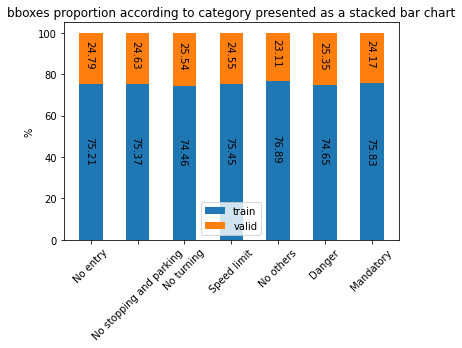

In [ ]:
data_images_train, data_images_valid = train_test_split(images, test_size = 0.25, random_state=67)

data_train_merge = pd.merge(data_images_train, annotations, left_on=['id'], right_on=['image_id'])
data_valid_merge = pd.merge(data_images_valid, annotations, left_on=['id'], right_on=['image_id'])

print('\ntrain images')
display(data_images_train)
print('\nvalid images')
display(data_images_valid)

train_category_proportion = (data_train_merge['category_id'].value_counts() / annotations['category_id'].value_counts()).sort_index()
valid_category_proportion = (data_valid_merge['category_id'].value_counts() / annotations['category_id'].value_counts()).sort_index()

#save to file for back up
data_images_train.to_csv(os.path.join(DATA_SRC, 'images_train.csv'), index=False)
data_images_valid.to_csv(os.path.join(DATA_SRC, 'images_valid.csv'), index=False)

'''plotting for better ilustration'''
% matplotlib inline
width = 0.5

b1 = plt.bar(
    categories.sort_values(by=['id'], ascending=True)['supercategory_eng'].values,
    train_category_proportion.values * 100,
    width,
    label='train'
)

b2 = plt.bar(
    categories.sort_values(by=['id'], ascending=True)['supercategory_eng'].values,
    valid_category_proportion * 100,
    width,
    label='valid',
    bottom=train_category_proportion.values * 100
)

for i in range(0, len(categories.sort_values(by=['id'], ascending=True)['supercategory_eng'].values)):
    plt.text(
        i - 0.15, #go to xtick
        (train_category_proportion.values * 100)[i] // 2, #go to the top, then divide by 2 -> go to center
        np.round((train_category_proportion.values * 100)[i], 2),
        rotation=-90
    )
    plt.text(
        i - 0.15, #go to xtick
        (train_category_proportion.values * 100)[i] + (valid_category_proportion.values * 100)[i] / 3,
        np.round((valid_category_proportion.values * 100)[i], 2),
        rotation=-90
    )

plt.xticks(rotation=45)

plt.ylabel('%')
plt.title('bboxes proportion according to category presented as a stacked bar chart')
plt.legend()

plt.show()

## generate YOLO data format

### generate ```<img_id>.txt``` file for each image ```<img_id>.png```

In [ ]:
def convert_coco_to_yolo_bbox(coco_bbox, img_dim):
    '''
    para
        coco_bbox : np.array [x_min, y_min, w, h] (4,)
        img_dim : [img_w, img_h] (2,)
    return
        yolo_bbox :|        ...
|   train.txt
 np.array [x_center_norm, y_center-norm, w_norm, h_norm] (4,)
    '''
    return np.array([
        (coco_bbox[0] + coco_bbox[2] / 2.0) / img_dim[0],
        (coco_bbox[1] + coco_bbox[3] / 2.0) / img_dim[1],
        coco_bbox[2] / img_dim[0],
        coco_bbox[3] / img_dim[1]
    ]).astype(np.float64)

In [ ]:
for _, image_row in images.iterrows():
    with open(os.path.join(DATA_SRC, 'images', '{}.txt'.format(image_row['id'])), "w") as annot_txt:
        buf = ''
        annot = annotations[annotations['image_id'] == image_row['id']]
        for _, annot_row in annot.iterrows():
            yolo_bbox = convert_coco_to_yolo_bbox(json.loads(annot_row['bbox']), [int(image_row['width']), int(image_row['height'])])
            buf += '{} {} {} {} {}\n'.format(int(annot_row['category_id']) - 1, yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3])
        annot_txt.write(buf)
        #print('write to {}'.format('{}.txt'.format(row['image_id'])))

### generate ```train.txt``` and ```valid.txt```

In [ ]:
data_images_train = pd.read_csv(os.path.join(DATA_SRC, 'images_train.csv'))
data_images_valid = pd.read_csv(os.path.join(DATA_SRC, 'images_valid.csv'))

```train.txt```

In [ ]:
with open(os.path.join(DATA_SRC, 'train.txt'), "w") as train_txt:
    train_buf = ''
    for _, row in data_images_train.iterrows():
        train_buf += ('data/images/{}\n'.format(row['file_name']))
    train_txt.write(train_buf) # [:-1] remove the last '\n'
    #print(train_buf[:-1])

```valid.txt```

In [ ]:
with open(os.path.join(DATA_SRC, 'valid.txt'), "w") as valid_txt:
    valid_buf = ''
    for _, row in data_images_valid.iterrows():
        valid_buf += ('data/images/{}\n'.format(row['file_name']))
    valid_txt.write(valid_buf) # [:-1] remove the last '\n'
    #print(valid_buf[:-1])

### generate ```classes.names```

In [ ]:
with open(os.path.join(DATA_SRC, 'classes.names'), "w") as classes_names:
    classes_buf = ''
    for _, row in categories.iterrows():
        classes_buf += ('{}\n'.format(row['supercategory_eng'].replace(' ', '_')))
    classes_names.write(classes_buf[:-1]) # [:-1] remove the last '\n'
    print(classes_buf[:-1])

No_entry
No_stopping_and_parking
No_turning
Speed_limit
No_others
Danger
Mandatory


### generate ```classes.data``` file

In [ ]:
with open(os.path.join(DATA_SRC, 'classes.data'), "w") as classes_data:
    buf = ''
    buf += 'classes = {}\n'.format(int(categories.shape[0]))
    buf += 'train = data/train.txt\n'
    buf += 'valid = data/valid.txt\n'
    buf += 'names = data/classes.names\n'
    buf += 'backup = backup'
    classes_data.write(buf)
    print(buf)

classes = 7
train = data/train.txt
valid = data/valid.txt
names = data/classes.names
backup = backup


## augmentate training images

### run augmentated compose pipeline

Get 50% of images to augmentate 1 time each image

In [ ]:
IMG_H = 626
IMG_W = 1622

In [ ]:
compose_pipeline = A.Compose([
    A.Resize(p=0.5, height=int(IMG_H), width=int(IMG_W / 1.5)),
    A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.1, 0.1), scale_limit=(-0.2, 0.2), rotate_limit=(-20, 20), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
    A.MotionBlur(always_apply=False, p=0.5, blur_limit=(3, 15)),
    A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.9, 1.2), per_channel=True, elementwise=True),
    A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True)
], bbox_params=A.BboxParams(format='coco', min_visibility=0.5, label_fields=['labels']))

In [ ]:
src_path=os.path.join(DATA_SRC, "images")
des_path=os.path.join(DATA_SRC, "images", "augmentated")
repeat_times=1

#number of images to be augmentated
N_IMGS_TO_AUG = int(data_images_train.shape[0] / 2)

aug_images_image_id_list = []
aug_images_image_repeated_list = []
aug_images_file_name_list = []
aug_images_width_list = []
aug_images_heigh_list = []

aug_annotations_image_id_list = []
aug_annotations_image_repeated_list = []
aug_annotations_bbox_list = []
aug_annotations_category_id_list = []

try:
    os.mkdir(des_path)
except:
    pass

train_images_samples = data_images_train.sample(n=N_IMGS_TO_AUG, replace=False)

for _, image_row in train_images_samples.iterrows():
    img_path = os.path.join(src_path, image_row['file_name'])
    with Image.open(img_path) as img:
        img_np = np.array(img)
        bboxes_annot = annotations[annotations['image_id'] == image_row['id']]
        for j in range(repeat_times):
            transformed_data = compose_pipeline(
                image=img_np,
                bboxes=[json.loads(bbox) for bbox in bboxes_annot['bbox'].values],
                labels=[category_id for category_id in bboxes_annot['category_id'].values]
            )
            transformed_file_name = '{}-augmentated-{}.png'.format(image_row['id'], j)
            #save <img_id>-augmentated.png to drive
            Image.fromarray(transformed_data['image']).save(os.path.join(des_path, transformed_file_name))

            #append to augmentated_annotation lists
            aug_images_image_id_list.append(int(image_row['id']))
            aug_images_image_repeated_list.append(int(j))
            aug_images_file_name_list.append(str(transformed_file_name))
            aug_images_width_list.append(int(transformed_data['image'].shape[1]))
            aug_images_heigh_list.append(int(transformed_data['image'].shape[0]))

            for bbox, label in zip(transformed_data['bboxes'], transformed_data['labels']):
                aug_annotations_image_id_list.append(int(image_row['id']))
                aug_annotations_image_repeated_list.append(int(j))
                aug_annotations_bbox_list.append(list(bbox))
                aug_annotations_category_id_list.append(int(label))

#save to annotation dataframe
aug_images = pd.DataFrame({
    'image_id': aug_images_image_id_list,
    'repeated': aug_images_image_repeated_list,
    'file_name': aug_images_file_name_list,
    'width': aug_images_width_list,
    'height': aug_images_heigh_list
})

aug_annotations = pd.DataFrame({
    'image_id': aug_annotations_image_id_list,
    'repeated': aug_annotations_image_repeated_list,
    'bbox': aug_annotations_bbox_list,
    'category_id': aug_annotations_category_id_list
})

aug_images.to_csv(os.path.join(DATA_SRC, 'aug_images.csv'), index=False)
aug_annotations.to_csv(os.path.join(DATA_SRC, 'aug_annotations.csv'), index=False)

In [ ]:
aug_images = pd.read_csv(os.path.join(DATA_SRC, 'aug_images.csv'))
aug_annotations = pd.read_csv(os.path.join(DATA_SRC, 'aug_annotations.csv'))

In [ ]:
display(aug_images)
display(aug_images.info())

,image_id,repeated,file_name,width,height
0,3473,0,3473-augmentated-0.png,1081,626
1,11781,0,11781-augmentated-0.png,1081,626
2,10380,0,10380-augmentated-0.png,1081,626
3,6662,0,6662-augmentated-0.png,1081,626
4,3092,0,3092-augmentated-0.png,1081,626
...,...,...,...,...,...
1682,6025,0,6025-augmentated-0.png,1622,626
1683,902,0,902-augmentated-0.png,1081,626
1684,6600,0,6600-augmentated-0.png,1622,626
1685,3009,0,3009-augmentated-0.png,1622,626


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   1687 non-null   int64 
 1   repeated   1687 non-null   int64 
 2   file_name  1687 non-null   object
 3   width      1687 non-null   int64 
 4   height     1687 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 66.0+ KB


None

In [ ]:
display(aug_annotations)
display(aug_annotations.info())

,image_id,repeated,bbox,category_id
0,3473,0,"[705.6355329820485, 256.04174525290995, 29.551...",6
1,11781,0,"[777.7601726263872, 351.0, 31.99013563501842, ...",6
2,10380,0,"[695.4662619315936, 329.63393753537014, 17.794...",6
3,10380,0,"[696.1592285336408, 330.44470927815644, 17.101...",6
4,10380,0,"[696.5469576824594, 329.63393753537014, 16.408...",6
...,...,...,...,...
4136,6600,0,"[1533.6005388323993, 195.92384675959283, 38.68...",3
4137,3009,0,"[776.0, 380.0, 9.0, 10.0]",6
4138,3009,0,"[1495.0, 319.0, 53.0, 71.99999999999994]",5
4139,9974,0,"[1345.6930526504227, 202.1170573756832, 82.062...",6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_id     4141 non-null   int64 
 1   repeated     4141 non-null   int64 
 2   bbox         4141 non-null   object
 3   category_id  4141 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 129.5+ KB


None

In [ ]:
aug_annotations[aug_annotations['image_id'] == 10011]

,image_id,repeated,bbox,category_id
2365,10011,0,"[699.2833823312857, 313.17590596884196, 70.900...",6
2366,10011,0,"[695.7354600089631, 390.1541916993691, 72.0583...",6
2367,10011,0,"[432.248475546284, 430.29945912961784, 3.14717...",1
2368,10011,0,"[431.65467383857924, 434.4870888088731, 3.2659...",7
2369,10011,0,"[695.972980692045, 396.43563621825206, 67.6196...",6
2370,10011,0,"[700.3373864883491, 318.4895922227851, 67.8572...",6
2371,10011,0,"[695.8542203505041, 396.43563621825206, 67.738...",6
2372,10011,0,"[701.0351096207899, 318.5687413776592, 67.1594...",6


create ```<img_id>-augmentated.txt```

In [ ]:
for _, image_row in aug_images.iterrows():
    with open(os.path.join(DATA_SRC, 'images', 'augmentated', '{}-augmentated-{}.txt'.format(image_row['image_id'], image_row['repeated'])), "w") as annot_txt:
        buf = ''
        annot = aug_annotations[(aug_annotations['image_id'] == image_row['image_id']) & (aug_annotations['repeated'] == image_row['repeated'])]
        for _, annot_row in annot.iterrows():
            yolo_bbox = convert_coco_to_yolo_bbox(json.loads(annot_row['bbox']), [int(image_row['width']), int(image_row['height'])])
            buf += '{} {} {} {} {}\n'.format(int(annot_row['category_id']) - 1, yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3])
        annot_txt.write(buf)

append img path to ```train.txt```

In [ ]:
with open(os.path.join(DATA_SRC, 'train.txt'), "a") as train_txt:
    train_buf = ''
    for _, row in aug_images.iterrows():
        train_buf += ('data/images/augmentated/{}\n'.format(row['file_name']))
    train_txt.write(train_buf)

After augmentatation, the training dataset has 3375 * 1.5 = 5062 records, valid set has 1125 records

### visualize random augmentated images with bboxes

In [ ]:
bbox_visualizer = BBoxVisualizer(
    box_color=(100, 255, 0),
    text_color=(0, 0, 0)
)

N_IMGS = 20

images_samples = aug_images.sample(n=N_IMGS, replace=False)
for _, image in images_samples.iterrows():
    annotation_samples = aug_annotations[(aug_annotations['image_id'] == image['image_id']) & (aug_annotations['repeated'] == image['repeated'])]
    img = cv2.imread(os.path.join(DATA_SRC, 'images', 'augmentated', image['file_name']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bbox_img = bbox_visualizer.visualize(
        img,
        [json.loads(bbox) for bbox in annotation_samples['bbox'].values],
        [categories[categories['id'] == label_id]['supercategory_eng'].values[0] for label_id in annotation_samples['category_id'].values],
        image['file_name'],
        'coco',
        'cv2'
    )
    #cv2.imwrite(os.path.join(DATA_SRC, 'sample_images', image['file_name']), cv2.cvtColor(bbox_img, cv2.COLOR_RGB2BGR))

Output hidden; open in https://colab.research.google.com to view.

## ```zip``` all relevant files

In [ ]:
os.chdir(DATA_SRC)
! zip -r data.zip images classes.names classes.data train.txt valid.txt 

### zip all 

In [ ]:
os.chdir(DATA_SRC)
! zip -r data_all.zip ./